In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle

from hydra import compose, initialize
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


In [3]:
sys.path.append('../')

In [4]:
with initialize(version_base=None, config_path="../runs/configs"):
    config = compose(config_name="split")
config

{'save_results': True, 'split_type': 'global_timesplit', 'split_params': {'quantile': None, 'validation_quantile': '${split_params.quantile}', 'validation_type': 'by_user', 'validation_size': None}, 'dataset': {'name': 'Movielens-1m', 'filter_seen': True, 'column_name': {'user_id': 'user_id', 'item_id': 'item_id', 'timestamp': 'timestamp', 'relevance': None}}}

In [5]:
DATASET="Zvuk"
config.update({"split_params": {"quantile": 0.9, 
                                 "validation_type": "by_time"}, 
               "split_type": "global_timesplit", 
               "dataset": {"name": DATASET}})

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
SEQ_SPLITS_DATA_PATH = "../data/"

In [8]:
def get_splitted_path(config):
    split_subtype = config.split_params.validation_type or ""
    q = (
        "q0" + str(config.split_params.quantile)[2:]
        if config.split_type == "global_timesplit"
        else ""
    )
    return os.path.join(
        os.path.join(
            SEQ_SPLITS_DATA_PATH,
            "splitted",
            config.split_type,
            f"val_{split_subtype}" if config.split_type == "global_timesplit" else "",
            config.dataset.name,
            q,
        )
    )

data_path = get_splitted_path(config)
data_path
prepr_path = os.path.join(
        SEQ_SPLITS_DATA_PATH, 'preprocessed')


In [9]:
with open(os.path.join(data_path,'time_threshold.pkl'), 'rb') as f:
    global_timepoint = pickle.load(f)
global_timepoint

1680935068.1974

In [10]:
prepr = pd.read_csv(os.path.join(prepr_path, config.dataset.name + '.csv'))
print('prepr shape', prepr.shape)
validation = pd.read_csv(os.path.join(data_path, 'validation.csv'))
print('validation shape', validation.shape)
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
print('test shape', test.shape)

max_item_id = max(prepr.item_id.max(), test.item_id.max(), validation.item_id.max())

prepr shape (8087953, 3)
validation shape (5774861, 3)
test shape (6379540, 3)


## Figure 4: Distribution of time gaps 

In [11]:
from runs.statistics import get_deltas, get_time_idx_reversed, get_two_last

In [12]:
user_col="user_id"
timestamp_col="timestamp"
df = test
df = df.sort_values([timestamp_col], kind='stable')

In [13]:
df_gt = get_time_idx_reversed(df[df[timestamp_col] > global_timepoint])
df_input = get_time_idx_reversed(df[df[timestamp_col] <= global_timepoint])
df_gt.shape, df_input.shape

((808796, 4), (5570744, 4))

In [14]:
last_input_item = df_input[df_input['time_idx_reversed'] == 0].drop(columns=['time_idx_reversed']).reset_index(drop=True)

In [15]:
delta_data = {}

In [16]:
delta_data["first"] = df_gt[df_gt["time_idx_reversed"] == df_gt.groupby("user_id")["time_idx_reversed"].transform(max)]
delta_data["successive"] = df_gt

In [17]:
np.random.seed(123)
random_gt_position = df_gt.groupby("user_id")["time_idx_reversed"].max().apply(lambda x: np.random.randint(0, x + 1))
delta_data["random"] = df_gt[df_gt["time_idx_reversed"] >= df_gt["user_id"].map(random_gt_position)]

In [18]:
for gt_name, current_gt_data in delta_data.copy().items():
    concatenated = pd.concat([last_input_item, current_gt_data[["user_id", "item_id", "timestamp"]]], ignore_index=True)
    if gt_name == "successive":
        delta_data["last"] = get_two_last(concatenated)
        delta_data[gt_name] = concatenated
    else:
        delta_data[gt_name] = get_two_last(concatenated)

In [19]:
delta_data_to_plot = []
labels = []
prepr = get_deltas(prepr)
delta_data_to_plot.append(np.log(1 + prepr["delta"][prepr["delta"] < prepr["delta"].quantile(0.99)]))
labels.append('Full data')

for gt_name, current_data in delta_data.items():
    current_deltas = get_deltas(current_data)
    delta_data_to_plot.append(np.log(1 + current_deltas["delta"][current_deltas["delta"] < current_deltas["delta"].quantile(0.99)]))
    labels.append(str.capitalize(gt_name))
    print(f"Kolmogorov-Smirnov test statistic for {labels[-1]}:", stats.kstest(current_deltas["delta"], prepr["delta"]).statistic)


Kolmogorov-Smirnov test statistic for First: 0.9105705353312016
Kolmogorov-Smirnov test statistic for Successive: 0.0871573717389269
Kolmogorov-Smirnov test statistic for Random: 0.1674627985788219
Kolmogorov-Smirnov test statistic for Last: 0.1312582602259933


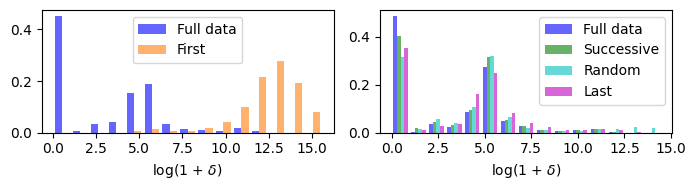

In [20]:
plt.figure(figsize=(7, 2))  
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2) 


ax1.hist(delta_data_to_plot[:2], alpha=0.6, bins=15, density=True, label=labels[:2], color=['b','tab:orange'])
ax1.set_xlabel('log(1 + $\delta$)')
ax1.legend()

ax2.hist([delta_data_to_plot[0], *delta_data_to_plot[2:]], alpha=0.6, bins=15, density=True, label=[labels[0], *labels[2:]], color=['b','g', 'c', 'm'])
ax2.set_xlabel('log(1 + $\delta$)')
ax2.legend()

plt.tight_layout()
plt.savefig("delta_hist.pdf")

plt.show()